In [1]:
!pip install lpips torchsummary scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.0 MB/s eta 0:00:00


In [2]:
from google.colab import files

# Upload the kaggle.json file you just downloaded
files.upload()

# Set up the Kaggle directory and permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Download the dataset
!kaggle datasets download kmljts/reside-6k
# Unzip if it's a zip file
!unzip dataset-name.zip

Dataset URL: https://www.kaggle.com/datasets/kmljts/reside-6k
License(s): apache-2.0
 97% 1.44G/1.48G [00:21<00:01, 27.9MB/s]
100% 1.48G/1.48G [00:21<00:00, 72.5MB/s]
unzip:  cannot find or open dataset-name.zip, dataset-name.zip.zip or dataset-name.zip.ZIP.


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as T
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
import time
import glob

# Configuration
class Config:
    height = 256  # Reduced for faster training on Colab/Kaggle
    width = 256
    train_batch_size = 8
    val_batch_size = 4
    num_epochs = 10
    lr = 0.0001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Path to your extracted Kaggle dataset
    base_path = '/content/my_dataset/RESIDE-6K'
    save_path = './snapshots/'

if not os.path.exists(Config.save_path):
    os.makedirs(Config.save_path)

config = Config()
loss_fn_lpips = lpips.LPIPS(net='alex').to(config.device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 181MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


In [5]:

import zipfile
import os

zip_path = '/content/reside-6k.zip'
extract_path = '/content/my_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/my_dataset


In [6]:

class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.pa(x)

class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.ca(self.avg_pool(x))

class EnhancedResBlock(nn.Module):
    def __init__(self, channel):
        super(EnhancedResBlock, self).__init__()
        # Change: Using Dilated Convolution (dilation=2) to expand receptive field
        self.conv1 = nn.Conv2d(channel, channel, 3, padding=2, dilation=2, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channel, channel, 3, padding=1, bias=True)
        self.ca = CALayer(channel)
        self.pa = PALayer(channel)

    def forward(self, x):
        res = self.relu(self.conv1(x))
        res = self.conv2(res)
        # Change: Integrated Feature Attention (CA + PA) inside the block
        res = self.ca(res)
        res = self.pa(res)
        return x + res  # Residual connection

class DehazeNet(nn.Module):
    def __init__(self, gps=3, dim=64):
        super(DehazeNet, self).__init__()
        self.gps, self.dim = gps, dim

        # Initial Extraction
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, dim, 3, 1, 1)

        # Deeper Residual Path with Enhanced Blocks
        self.res_blocks = nn.ModuleList([EnhancedResBlock(dim) for _ in range(10)])

        # Weighted Fusion Attention
        self.fusion_ca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(dim * 3, dim // 4, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim // 4, dim * 3, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

        self.post = nn.Sequential(
            nn.Conv2d(dim, 32, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, 1, 1)
        )

    def forward(self, x):
        # Initial features
        feat_initial = torch.relu(self.conv2(torch.relu(self.conv1(x))))

        # FIX: Iterate through ModuleList manually
        res_out = feat_initial
        y1, y2, y3 = None, None, None

        for i, block in enumerate(self.res_blocks):
            res_out = block(res_out)
            if i == 2: y1 = res_out  # After 3 blocks
            if i == 6: y2 = res_out  # After 7 blocks
        y3 = res_out                 # After 10 blocks

        # Dynamic Fusion
        combined = torch.cat([y1, y2, y3], dim=1)
        weights = self.fusion_ca(combined)
        fused = combined * weights

        # Split and sum (Weighted skip connections)
        y = fused[:, :self.dim, :, :] + \
            fused[:, self.dim:self.dim*2, :, :] + \
            fused[:, self.dim*2:, :, :]

        out = self.post(y)
        return torch.relu(x + out)

In [7]:
class Reside6kLoader(Dataset):
    def __init__(self, hazy_path, clear_path, size=256):
        self.hazy_imgs = sorted(glob.glob(os.path.join(hazy_path, "*.*")))
        self.clear_path = clear_path
        self.size = size

    def __getitem__(self, index):
        hazy_path = self.hazy_imgs[index]
        # Match filename for clear image (adjust if naming convention differs)
        filename = os.path.basename(hazy_path).split('_')[0] + ".jpg"
        clear_path = os.path.join(self.clear_path, filename)

        if not os.path.exists(clear_path): # fallback to name matching
             clear_path = os.path.join(self.clear_path, os.path.basename(hazy_path))

        hazy = Image.open(hazy_path).convert('RGB').resize((self.size, self.size))
        clear = Image.open(clear_path).convert('RGB').resize((self.size, self.size))

        transform = T.Compose([T.ToTensor()])
        return transform(clear), transform(hazy)

    def __len__(self): return len(self.hazy_imgs)

# --- Initialize Splits ---
# Assuming structure: base/train/hazy, base/train/clear
full_train_ds = Reside6kLoader(
    "/content/my_dataset/RESIDE-6K/train/hazy",
    "/content/my_dataset/RESIDE-6K/train/GT"
)
train_size = int(0.823 * len(full_train_ds)) # 70% of total (70/85)
val_size = len(full_train_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [train_size, val_size])
test_ds = Reside6kLoader(
    "/content/my_dataset/RESIDE-6K/test/hazy",
    "/content/my_dataset/RESIDE-6K/test/GT"
)

train_loader = DataLoader(train_ds, batch_size=config.train_batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config.val_batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=config.val_batch_size, shuffle=False)

In [9]:


def compute_metrics(gt, pred):
    # Convert to numpy for skimage
    gt_np = gt.detach().cpu().numpy().transpose(0, 2, 3, 1)
    pred_np = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)

    # Calculate MSE across the batch
    mse = np.mean((gt_np - pred_np)**2)

    # Calculate average PSNR and SSIM for the batch
    psnr_val = 0
    ssim_val = 0
    batch_size = gt_np.shape[0]
    for i in range(batch_size):
        psnr_val += peak_signal_noise_ratio(gt_np[i], pred_np[i], data_range=1.0)
        ssim_val += structural_similarity(gt_np[i], pred_np[i], channel_axis=-1, data_range=1.0)

    # LPIPS fix: take the mean of the batch scores
    # loss_fn_lpips returns a [Batch, 1, 1, 1] tensor
    lp_tensor = loss_fn_lpips(gt * 2 - 1, pred * 2 - 1)
    lp = torch.mean(lp_tensor).item()

    return mse, psnr_val/batch_size, ssim_val/batch_size, lp
    return mse, psnr, ssim, lp

def validate(model, loader, name="Validation"):
    model.eval()
    m_mse, m_psnr, m_ssim, m_lp = [], [], [], []
    with torch.no_grad():
        for gt, hazy in loader:
            gt, hazy = gt.to(config.device), hazy.to(config.device)
            out = torch.clamp(model(hazy), 0, 1)
            mse, psnr, ssim, lp = compute_metrics(gt, out)
            m_mse.append(mse); m_psnr.append(psnr); m_ssim.append(ssim); m_lp.append(lp)

    print(f"\n--- {name} Results ---")
    print(f"MSE: {np.mean(m_mse):.4f} | PSNR: {np.mean(m_psnr):.2f} | SSIM: {np.mean(m_ssim):.4f} | LPIPS: {np.mean(m_lp):.4f}")
    return np.mean(m_psnr)

# --- Training Loop ---
# --- Setup ---
model = DehazeNet().to(config.device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
# New: Scheduler to improve convergence on RESIDE
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)
criterion = nn.L1Loss()

for epoch in range(config.num_epochs):
    model.train()
    total_loss = 0

    for gt, hazy in train_loader:
        gt, hazy = gt.to(config.device), hazy.to(config.device)

        optimizer.zero_grad()
        out = model(hazy)
        loss = criterion(out, gt)
        loss.backward()

        # Optional: Gradient clipping to prevent exploding gradients in deeper models
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()
        total_loss += loss.item()

    # Step the scheduler every epoch
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{config.num_epochs} | Loss: {total_loss/len(train_loader):.4f} | LR: {current_lr:.6f}")

    if (epoch + 1) % 5 == 0:
        validate(model, val_loader)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f"dehaze_v2_epoch_{epoch+1}.pth")

Epoch 1/10 | Loss: 0.0996 | LR: 0.000098
Epoch 2/10 | Loss: 0.0908 | LR: 0.000090
Epoch 3/10 | Loss: 0.0884 | LR: 0.000079
Epoch 4/10 | Loss: 0.0834 | LR: 0.000065
Epoch 5/10 | Loss: 0.0767 | LR: 0.000050

--- Validation Results ---
MSE: 0.0152 | PSNR: 21.84 | SSIM: 0.8425 | LPIPS: 0.1145
Epoch 6/10 | Loss: 0.0731 | LR: 0.000035
Epoch 7/10 | Loss: 0.0689 | LR: 0.000021
Epoch 8/10 | Loss: 0.0664 | LR: 0.000010
Epoch 9/10 | Loss: 0.0636 | LR: 0.000002
Epoch 10/10 | Loss: 0.0622 | LR: 0.000000

--- Validation Results ---
MSE: 0.0092 | PSNR: 23.04 | SSIM: 0.8435 | LPIPS: 0.1104



--- Final Test Results ---
MSE: 0.0063 | PSNR: 23.59 | SSIM: 0.8848 | LPIPS: 0.0669


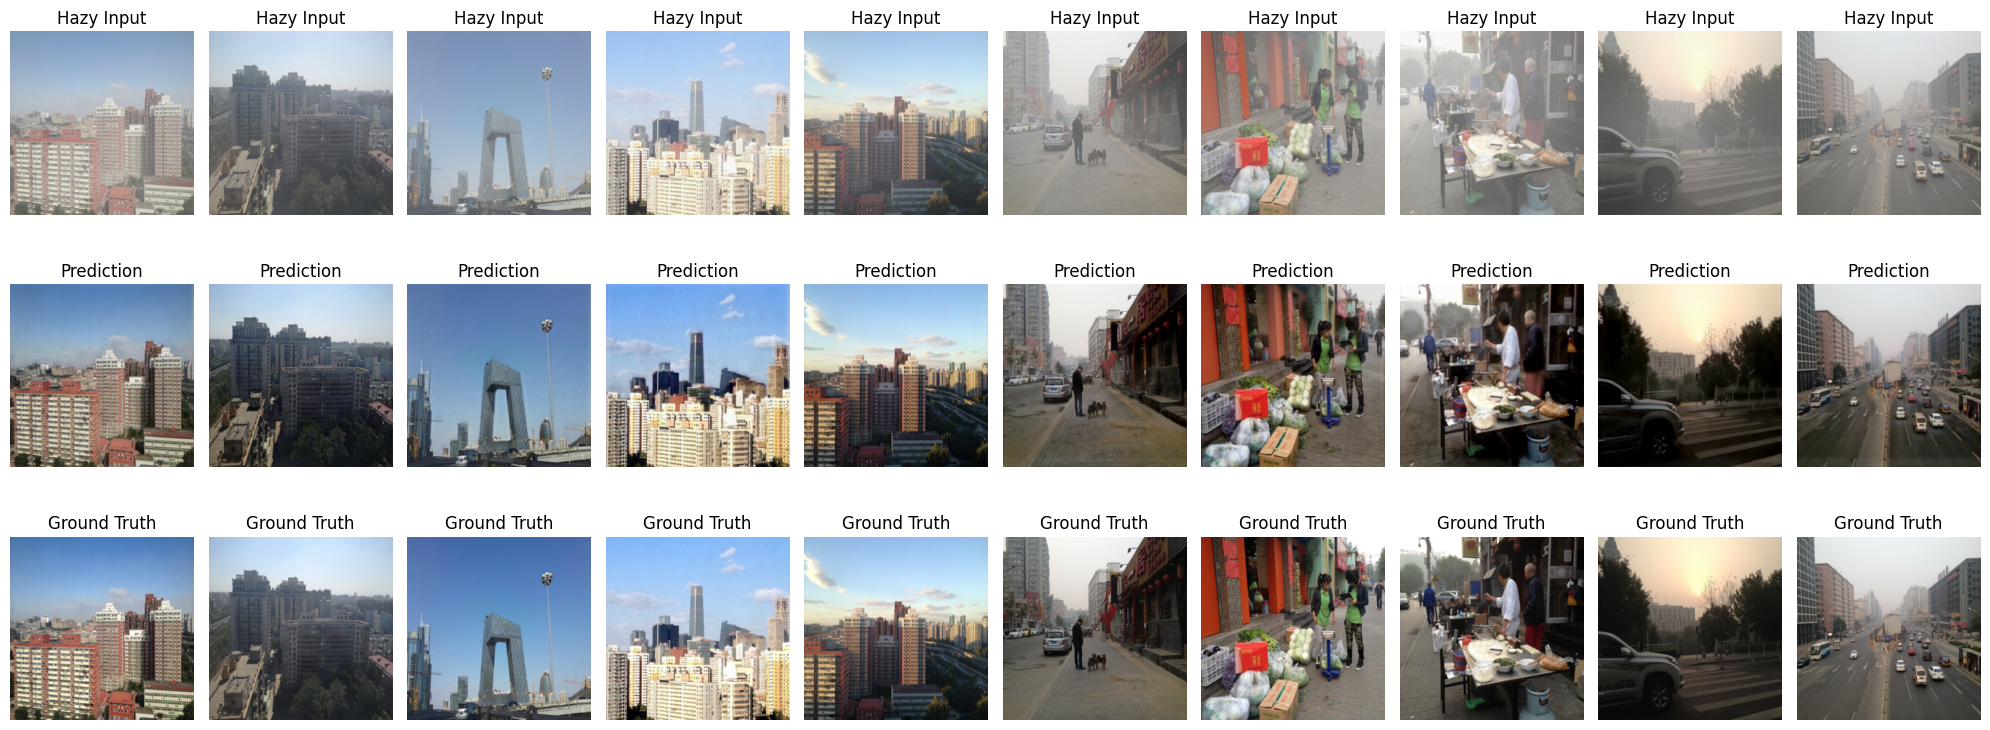

In [10]:
def visualize_results(model, dataset, num_samples=10):
    model.eval()
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 8))

    for i in range(num_samples):
        gt, hazy = dataset[i]
        with torch.no_grad():
            out = model(hazy.unsqueeze(0).to(config.device))
            out = torch.clamp(out, 0, 1).cpu().squeeze(0)

        # Plotting
        axes[0, i].imshow(hazy.permute(1, 2, 0))
        axes[0, i].set_title("Hazy Input")
        axes[0, i].axis('off')

        axes[1, i].imshow(out.permute(1, 2, 0))
        axes[1, i].set_title("Prediction")
        axes[1, i].axis('off')

        axes[2, i].imshow(gt.permute(1, 2, 0))
        axes[2, i].set_title("Ground Truth")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# Run for Test Set
validate(model, test_loader, name="Final Test")
visualize_results(model, test_ds)